## Create and test ion channel model

In [1]:
import myokit
import myokit.lib.hh as hh
import numpy as np

In [2]:
m = myokit.load_model('models/icat_markov.mmt')

In [3]:
v = m.get('membrane.V')
v.demote()
v.set_rhs(0)
v.set_binding('pace')

In [4]:
states = [
    'icat.a',
    'icat.r',
]
parameters = [
    'icat.p_1',
    'icat.p_2',
    'icat.p_3',
    'icat.p_4',
    'icat.p_5',
    'icat.p_6',
    'icat.p_7',
    'icat.p_8',
    'icat.g_CaT'
]
current = 'icat.i_CaT'

In [5]:
mm = hh.HHModel(m, states, parameters, current, vm='membrane.V')

In [6]:
# Current-voltage relationship
steps = np.arange(-75, 40, 5)
p1 = myokit.pacing.steptrain(
         vsteps=steps,
         vhold=-75,
         tpre=1000,
         tstep=300,
     )
t1 = p1.characteristic_time()
s1 = hh.AnalyticalSimulation(mm, p1)

In [7]:
# Inactivation protocol
steps = np.arange(-80, -20, 5)
p2 = myokit.pacing.steptrain_linear(
         vstart=-80,
         vend=-20,
         dv=5,
         vhold=-10,
         tpre=1000,
         tstep=1000,
         tpost=200,
     )
t2 = p2.characteristic_time()
s2 = hh.AnalyticalSimulation(mm, p2)

In [8]:
# Recovery protocol
steps = [32, 64, 96, 128, 160, 192, 224, 256, 288, 320]
vhold = -80
vpulse = -20
p3 = myokit.Protocol()
for step in steps:
    p3.add_step(vhold, 5000)
    p3.add_step(vpulse, 300)
    p3.add_step(vhold, step)
    p3.add_step(vpulse, 300)
t3 = p3.characteristic_time()
s3 = hh.AnalyticalSimulation(mm, p3)

In [9]:
from collections import OrderedDict
class ABCModel(object):
    def __init__(self, mm, ss, tt):
        self.mm = mm
        self.ss = ss
        self.tt = tt
        
        self.defaults = OrderedDict(zip(mm.parameters(), mm.default_parameters()))
    
    def __call__(self, parameters):
        new_parameters = self.defaults
        for name, value in parameters.items():
            new_parameters[name] = value
        
        for s in self.ss:
            s.reset()
            s.set_parameters(list(new_parameters.values()))
            
        return [s.run(t) for s,t in zip(self.ss,self.tt)]

In [10]:
model = ABCModel(mm, [s1,s2], [t1,t2])

In [25]:
# Measurement of raw output
def sum_stats(sim_output):
    out = {}
    cnt = 0
    raw_data = sim_output["data"]
    
    # I-V curve
    d0 = raw_data[0].split_periodic(1300)
    for d in d0:
        d = d.trim_left(1000, adjust=True)
        current = d['icat.i_CaT']
        index = np.argmax(np.abs(current))
        out[str(cnt)] = current[index]
        cnt += 1
    
    # Activation data
    activation = []
    for d in d0:
        current = d['icat.i_CaT']
        index = np.argmax(np.abs(current))
        activation.append(abs(current[index]))
    max_activation = np.max(activation)
    activation = [a/max_activation for a in activation]
    for a in activation:
        out[str(cnt)] = a
        cnt += 1
        
    # Inactivation data
    d1 = raw_data[1].split_periodic(2200)
    inactivation = []
    for d in d1:
        d.trim_left(2000, adjust=True)
        current = d['icat.i_CaT']
        index = np.argmax(np.abs(current))
        inactivation.append(abs(current[index]))
    max_inactivation = np.max(inactivation)
    inactivation = [i/max_inactivation for i in inactivation]
    for i in inactivation:
        out[str(cnt)] = i
        cnt += 1
    return out

In [26]:
from data.icat.data_icat import IV_Nguyen, Act_Nguyen, Inact_Nguyen

In [27]:
obs = IV_Nguyen()[1] + Act_Nguyen()[1] + Inact_Nguyen()[1]
obs = dict(zip(np.arange(len(obs)).tolist(),obs))

In [28]:
exp = ([0 for _ in range(len(IV_Nguyen()[1]))] + 
       [1 for _ in range(len(Act_Nguyen()[1]))] + 
       [2 for _ in range(len(Inact_Nguyen()[1]))])
exp = dict(zip(np.arange(len(exp)).tolist(), exp))

In [15]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler
from pyabc.populationstrategy import AdaptivePopulationSize

In [16]:
limits = {'icat.g_CaT': (0, 10.),
          'icat.p_1': (-20, 0),
          'icat.p_2': (0, 1.),
          'icat.p_3': (-20, 0),
          'icat.p_4': (0, 1.),
          'icat.p_5': (-20, 0),
          'icat.p_6': (0, 1.),
          'icat.p_7': (-20, 0),
          'icat.p_8': (0, 1.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [17]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat_markov.db"))
print(db_path)

sqlite:////var/folders/18/lbp63zt51g90fcjs73tbh1x80000gn/T/hl-1_icat_markov.db


In [18]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [19]:
from ionchannelABC import IonChannelDistance, IonChannelAcceptor, EfficientMultivariateNormalTransition

In [29]:
def simulate_pyabc(parameter):
    res = model(parameter)
    return {"data": res}

In [21]:
from pyabc.populationstrategy import ConstantPopulationSize

In [22]:
abc = ABCSMC(models=simulate_pyabc,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp),
             population_size=ConstantPopulationSize(20),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=50,
             #    mean_cv=0.2,
             #    max_population_size=5000,
             #    min_population_size=1000),
             summary_statistics=sum_stats,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=2),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.3821236538745274, 1: 0.3821236538745274, 2: 0.3821236538745274, 3: 0.3821236538745274, 4: 0.3821236538745274, 5: 0.3821236538745274, 6: 0.3821236538745274, 7: 0.3821236538745274, 8: 0.3821236538745274, 9: 0.3821236538745274, 10: 0.3821236538745274, 11: 0.3821236538745274, 12: 0.3821236538745274, 13: 0.3821236538745274, 14: 0.3821236538745274, 15: 0.3821236538745274, 16: 0.3821236538745274, 17: 0.3821236538745274, 18: 0.3821236538745274, 19: 0.3821236538745274, 20: 0.3821236538745274, 21: 0.3821236538745274, 22: 0.3821236538745274, 23: 1.3696551482810722, 24: 1.3696551482810722, 25: 1.3696551482810722, 26: 1.3696551482810722, 27: 1.3696551482810722, 28: 1.3696551482810722, 29: 1.3696551482810722, 30: 1.3696551482810722, 31: 1.3696551482810722, 32: 1.3696551482810722, 33: 1.3696551482810722, 34: 1.3696551482810722, 35: 1.3696551482810722, 36: 1.3696551482810722, 37: 1.3696551482810722, 38: 1.3696551482810722, 39: 1.3696551482810722, 40: 1.660584870008

In [23]:
abc_id = abc.new(db_path, obs)

In [24]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=5, min_acceptance_rate=0.01)

INFO:Epsilon:initial epsilon is 646.4147602628791
INFO:ABC:t:0 eps:646.4147602628791
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 50
DEBUG:Epsilon:new eps, t=1, eps=19.84933617042568
INFO:ABC:t:1 eps:19.84933617042568
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 90
DEBUG:Epsilon:new eps, t=2, eps=13.4283474484548
INFO:ABC:t:2 eps:13.4283474484548
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 133
DEBUG:Epsilon:new eps, t=3, eps=13.167806747739801
INFO:ABC:t:3 eps:13.167806747739801
DEBUG:ABC:now submitting population 3
Process Process-9:
Traceback (most recent call last):
  File "/usr/local/miniconda3/envs/ionchannelABC/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/miniconda3/envs/ionchannelABC/lib/python3.7/multiprocessing/process.py",

KeyboardInterrupt: 

# Get experimental measurements

In [128]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

NameError: name 'model' is not defined

## Set limits and generate uniform initial priors

In [7]:
limits = dict(g_CaT=(0, 10.),
              p_1=(-20, 0),
              p_2=(0, 1.),
              p_3=(-20, 0),
              p_4=(0, 1.),
              p_5=(-20, 0),
              p_6=(0, 1.),
              p_7=(-20, 0),
              p_8=(0, 1.))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [8]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat_markov.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat_markov.db


In [9]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [12]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=pop_size,
                 mean_cv=0.4,
                 max_population_size=10000,
                 min_population_size=pop_size),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=50),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.27372127210799024, 1: 0.27372127210799024, 2: 0.27372127210799024, 3: 0.27372127210799024, 4: 0.27372127210799024, 5: 0.27372127210799024, 6: 0.27372127210799024, 7: 0.27372127210799024, 8: 0.27372127210799024, 9: 0.27372127210799024, 10: 0.27372127210799024, 11: 0.27372127210799024, 12: 0.27372127210799024, 13: 0.27372127210799024, 14: 0.27372127210799024, 15: 0.27372127210799024, 16: 0.27372127210799024, 17: 0.27372127210799024, 18: 0.27372127210799024, 19: 0.27372127210799024, 20: 0.27372127210799024, 21: 0.27372127210799024, 22: 0.27372127210799024, 23: 0.9811058429265805, 24: 0.9811058429265805, 25: 0.9811058429265805, 26: 0.9811058429265805, 27: 0.9811058429265805, 28: 0.9811058429265805, 29: 0.9811058429265805, 30: 0.9811058429265805, 31: 0.9811058429265805, 32: 0.9811058429265805, 33: 0.9811058429265805, 34: 0.9811058429265805, 35: 0.9811058429265805, 36: 0.9811058429265805, 37: 0.9811058429265805, 38: 0.9811058429265805, 39: 0.9811058429265

In [13]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-05-26 10:16:56.241530, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:50
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 1970
DEBUG:Epsilon:new eps, t=1, eps=10.407369847235092
INFO:ABC:t:1 eps:10.407369847235092
INFO:Adaptation:Change nr particles 512 -> 6783
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 18165
DEBUG:Epsilon:new eps, t=2, eps=10.23245976886391
INFO:ABC:t:2 eps:10.23245976886391


# Results analysis

In [14]:
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2019-05-24 14:25:11.788596, end_time=None)>,
 <ABCSMC(id=2, start_time=2019-05-24 14:28:14.836867, end_time=2019-05-24 21:33:21.172792)>,
 <ABCSMC(id=3, start_time=2019-05-25 10:21:46.245833, end_time=None)>,
 <ABCSMC(id=4, start_time=2019-05-25 10:26:01.160694, end_time=None)>,
 <ABCSMC(id=5, start_time=2019-05-25 10:39:29.529116, end_time=None)>,
 <ABCSMC(id=6, start_time=2019-05-25 17:03:55.787641, end_time=2019-05-26 05:32:26.112632)>]

In [15]:
history.id = 6

In [16]:
sns.set_context('talk')

In [17]:
df, w = history.get_distribution(m=0)

In [18]:
df.describe()

name,g_CaT,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.998681,-3.171813,0.070098,-6.369770,0.127757,-0.673849,0.077178,-10.008042,0.062547
std,0.001063,0.006599,0.000252,0.007416,0.000220,0.008212,0.000255,0.011747,0.000192
min,9.993480,-3.191262,0.069496,-6.390543,0.127053,-0.693986,0.076594,-10.041697,0.061982
25%,9.998145,-3.176421,0.069929,-6.374603,0.127604,-0.679523,0.077012,-10.016291,0.062402
50%,9.998930,-3.171691,0.070065,-6.369713,0.127753,-0.674604,0.077130,-10.008028,0.062544
75%,9.999521,-3.167300,0.070208,-6.364821,0.127902,-0.668883,0.077281,-9.999752,0.062687
max,10.000000,-3.146690,0.070969,-6.342701,0.128521,-0.640754,0.078072,-9.973300,0.063129


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make ax

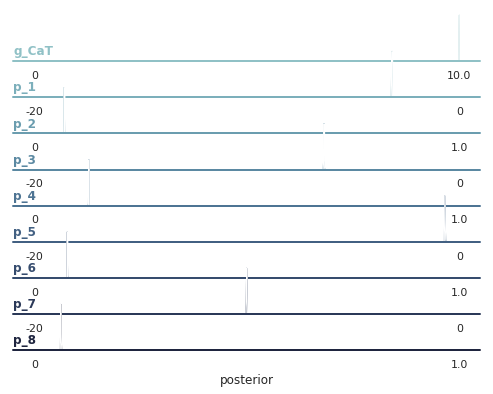

In [19]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits,aspect=12,height=0.6)

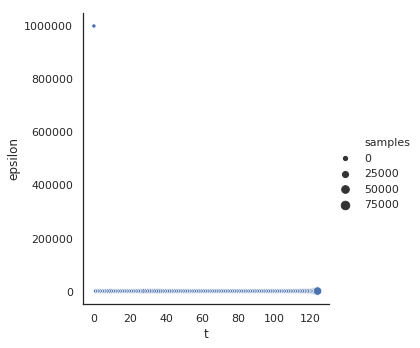

In [48]:
evolution = history.get_all_populations()
g = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
#g.savefig('results/icat-generic/eps_evolution.pdf')

# Samples for quantitative analysis

In [20]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [21]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

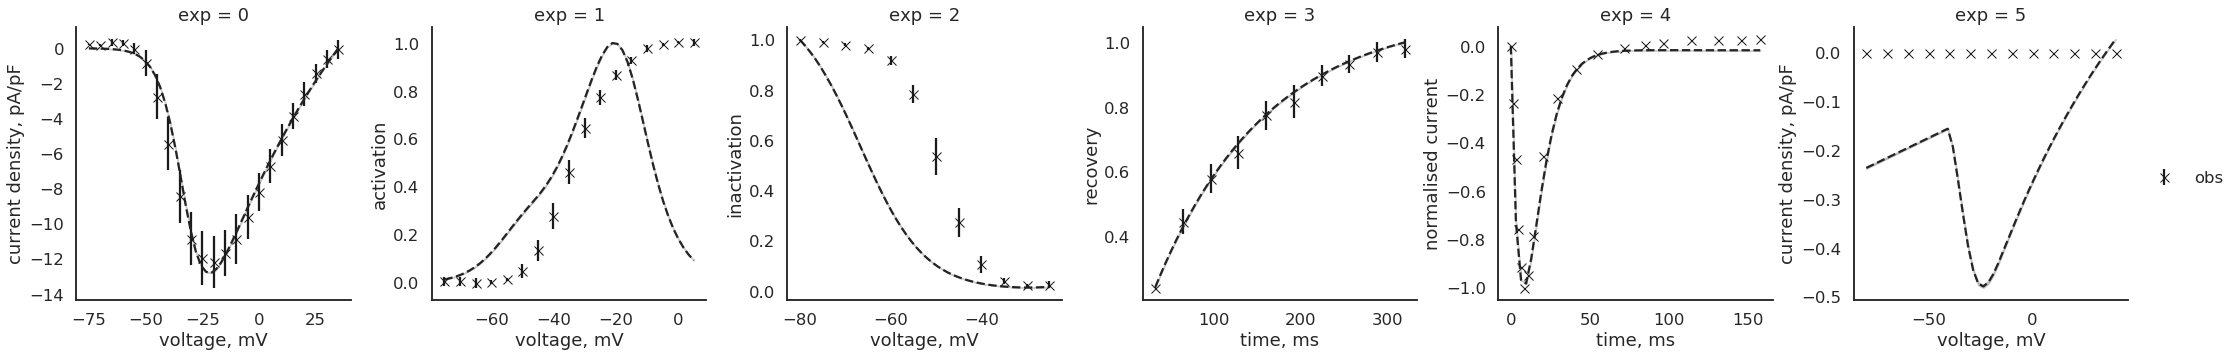

In [22]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [70]:
g.savefig('results/icat-generic/icat_sim_results.pdf')

In [71]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

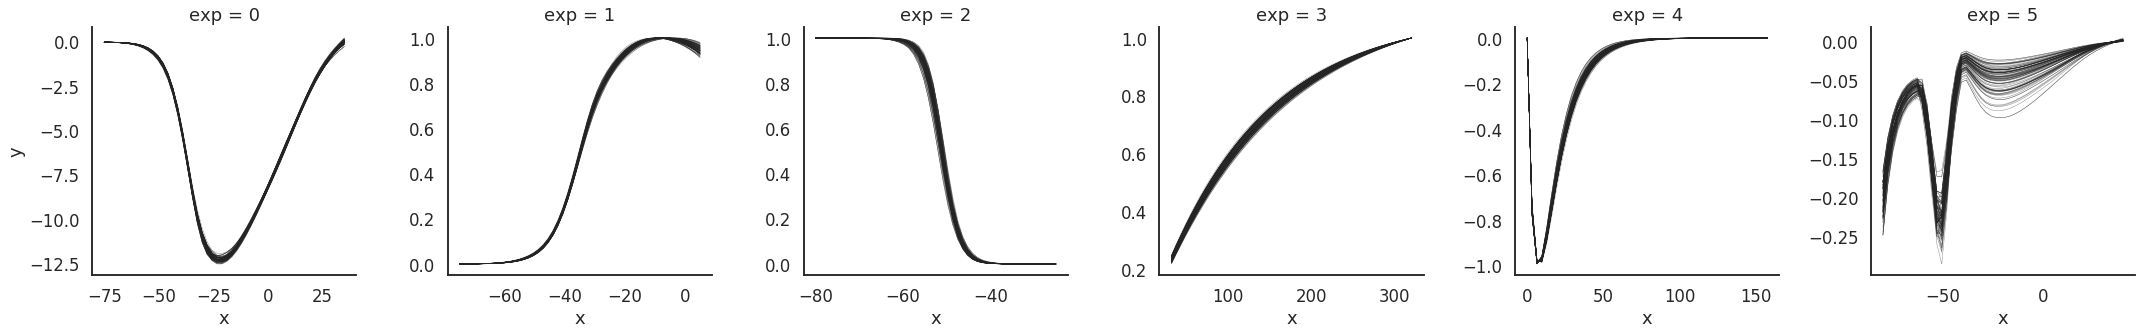

In [72]:
grid2 = plot_sim_results_all(samples)

In [73]:
grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [74]:
# Mean current density
print(np.mean(samples[samples.exp==0].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp==0].groupby('sample').min()['y']))

-12.28849522978163
0.11884277718478846


In [75]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [76]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -12.305081453952692
95% CI: (-12.500217629136861, -12.042063814242947)


In [77]:
# Voltage of peak current density
idxs = samples[samples.exp==0].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -21.885714285714286
STD: 1.0634278539232422


In [78]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -21.122448979591837
95% CI: (-23.367346938775512, -21.122448979591837)


In [79]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [80]:
print(np.mean(output))
print(np.std(output))

0   -34.577896
1     5.249907
dtype: float64
0    0.235155
1    0.153233
dtype: float64


In [81]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.58363058983856
95% CI: (-35.0824309590915, -34.05139450727638)


In [82]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.224802366288811
95% CI: (4.983346458403857, 5.580422234103727)


In [83]:
# Half activation potential
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [84]:
print(np.mean(output))
print(np.std(output))

0   -51.099701
1     2.015624
dtype: float64
0    0.324099
1    0.124022
dtype: float64


In [85]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -51.139541001530084
95% CI: (-51.91973135023897, -50.483201273719196)


In [86]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 1.9931521591606465
95% CI: (1.7945341598364295, 2.2778268479073294)


In [87]:
# Recovery time constant
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [88]:
print(np.mean(output))
print(np.std(output))

134.15783981052365
6.8765524851314765


In [89]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 134.09052469517178
95% CI: (124.17078543531227, 147.7723663936914)
